### Import Libraries and Files

In [1]:
import numpy as np
import arviz as az
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3 import traceplot

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Take data from CSV files

In [2]:
vad_arousal = pd.read_csv(r'../Lexicons/NRC_VAD_Lexicon/NRC-VAD-Lexicon-a-scores.csv')
vad_valence = pd.read_csv(r'../Lexicons/NRC_VAD_Lexicon/NRC-VAD-Lexicon-v-scores.csv')
vad_dominance = pd.read_csv(r'../Lexicons/NRC_VAD_Lexicon/NRC-VAD-Lexicon-d-scores.csv')
zuco_cs = pd.read_csv(r'../Lexicons/ZuCo_words_dataset.csv')

In [3]:
zuco_ar_cs = pd.merge(vad_arousal,zuco_cs, how = 'inner', on = ['Word'])
zuco_ar_cs = zuco_ar_cs.sort_values(by=['Arousal']).reset_index(drop=True)
zuco_ar_cs = zuco_ar_cs.drop(['Word'], axis=1)

zuco_va_cs = pd.merge(zuco_cs, vad_valence, how = 'inner', on = ['Word'])
zuco_va_cs = zuco_va_cs.sort_values(by=['Valence']).reset_index(drop=True)
zuco_va_cs = zuco_va_cs.drop(['Word'], axis=1)

zuco_do_cs = pd.merge(zuco_cs, vad_dominance, how = 'inner', on = ['Word'])
zuco_do_cs = zuco_do_cs.sort_values(by=['Dominance']).reset_index(drop=True)
zuco_do_cs = zuco_do_cs.drop(['Word'], axis=1)

### Model building: ZuCo-VAD BLR: Arousal (No normalization for VAD)

In [13]:
AR_GF_cs = pd.DataFrame(zuco_ar_cs, columns=['Arousal','MPS','TRT','GD','FFD'])
scaler = MinMaxScaler()

x = AR_GF_cs[['MPS','TRT','GD', 'FFD']]
x = pd.DataFrame(scaler.fit_transform(x), columns=['MPS','TRT','GD','FFD'])
Arousal = AR_GF_cs['Arousal']

formula = 'Arousal ~ ' + ' + '.join(['%s' % variable for variable in x.columns[:]])
print(formula)

# Context for the model


           MPS       TRT        GD       FFD
0     0.560214  0.241078  0.175039  0.119586
1     0.724663  0.337293  0.127131  0.099264
2     0.594563  0.105218  0.161890  0.227152
3     0.461788  0.192033  0.294492  0.186200
4     0.584273  0.307068  0.264194  0.225947
...        ...       ...       ...       ...
997   0.460872  0.379648  0.304771  0.189087
998   0.375266  0.215825  0.330832  0.450867
999   0.649017  0.268238  0.341297  0.272927
1000  0.534821  0.098046  0.087173  0.128212
1001  0.448193  0.194276  0.252442  0.281068

[1002 rows x 4 columns]
Arousal ~ MPS + TRT + GD + FFD


In [15]:
with pm.Model() as normal_model:
        
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
# Creating the model requires a formula and data (and optionally a family)
    model = pm.GLM.from_formula(formula, data = x, family = family)
# Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500)
#model.summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, FFD, GD, TRT, MPS, Intercept]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 2422 seconds.


<ipython-input-18-f4abab5c2ed6>:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout();
c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'MPS'}>,
        <AxesSubplot:title={'center':'TRT'}>],
       [<AxesSubplot:title={'center':'GD'}>,
        <AxesSubplot:title={'center':'FFD'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

<Figure size 504x504 with 0 Axes>

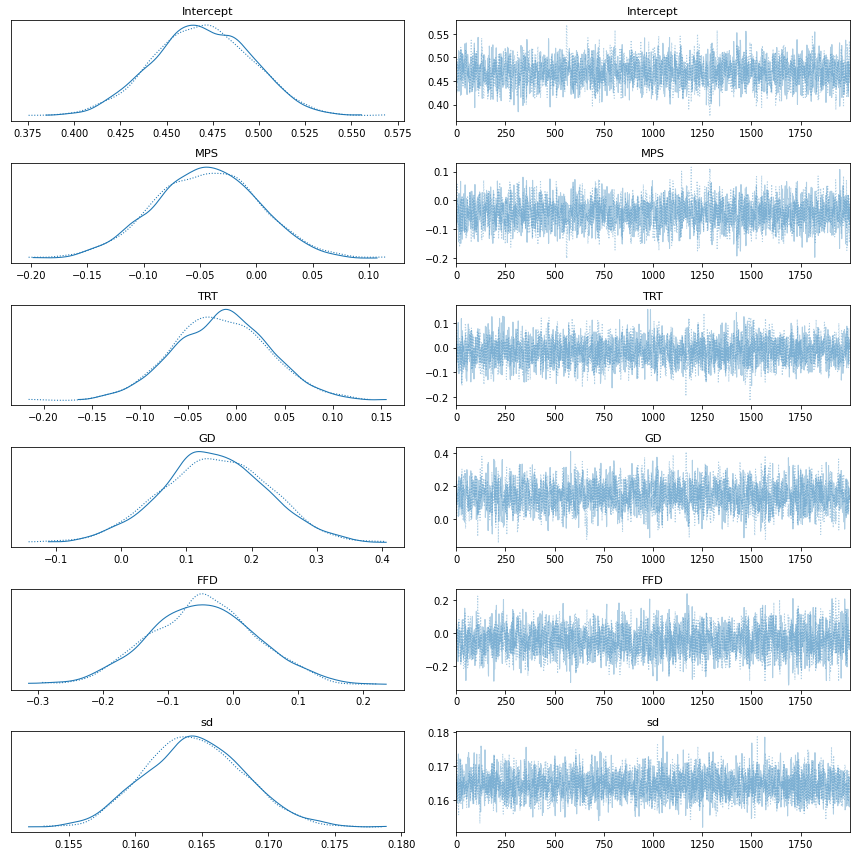

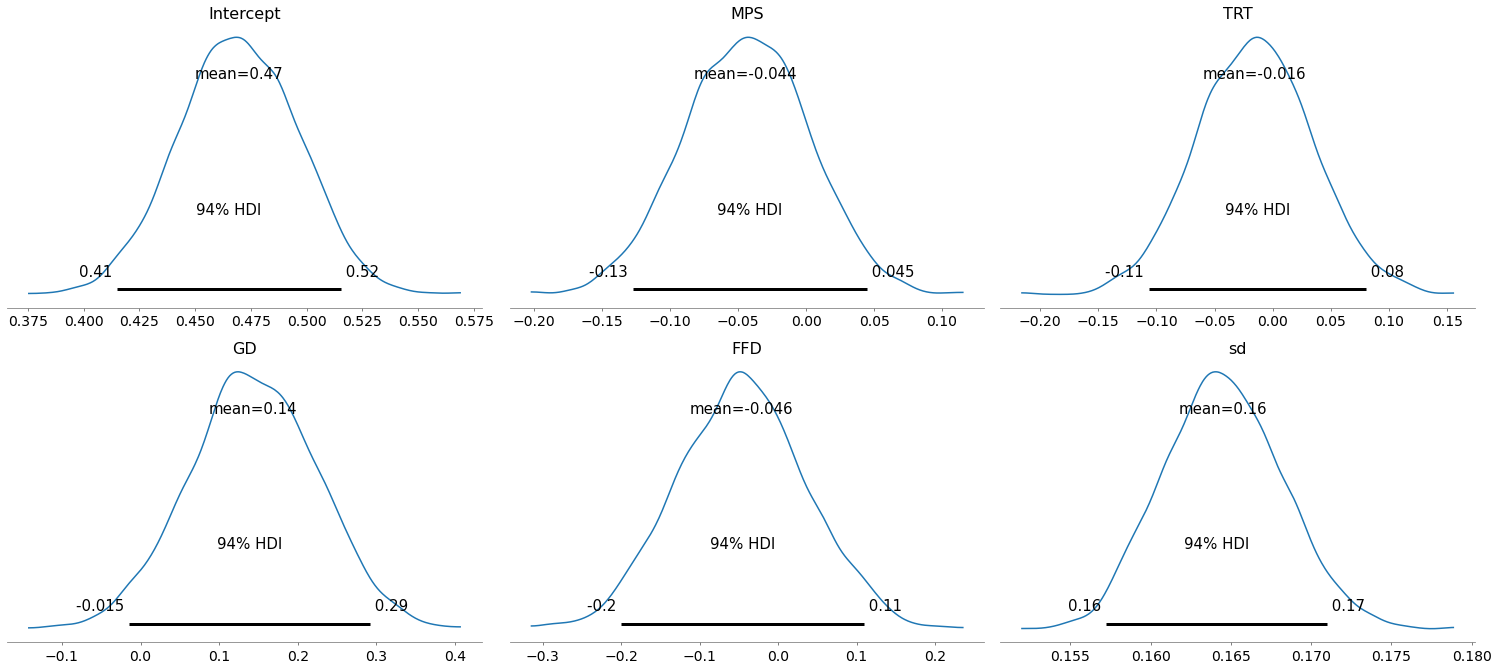

In [18]:
plt.figure(figsize=(7, 7))
traceplot(normal_trace)
plt.tight_layout();
pm.plot_posterior(normal_trace)

In [20]:
def evaluate_prediction(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    
    return mae, rmse

In [5]:

median_pred = Arousal.median()
median_preds = [median_pred for _ in range(len(Arousal))]
true = Arousal
# Display mae and rmse
mae, rmse = evaluate_prediction(median_preds, true)
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Root Mean Square Error: {:.4f}'.format(rmse))

NameError: name 'Arousal' is not defined

In [22]:
az.summary(normal_trace, round_to=2)

c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.47,0.03,0.41,0.52,0.0,0.0,2115.74,2113.72,2113.60,2100.65,1.0
MPS,-0.04,0.05,-0.13,0.05,0.0,0.0,2260.70,2085.36,2260.38,2352.42,1.0
TRT,-0.02,0.05,-0.11,0.08,0.0,0.0,2889.53,1758.66,2904.70,2666.96,1.0
GD,0.14,0.08,-0.02,0.29,0.0,0.0,2170.00,2116.56,2170.21,2227.13,1.0
FFD,-0.05,0.08,-0.20,0.11,0.0,0.0,2377.85,2377.85,2376.62,2429.80,1.0
sd,0.16,0.00,0.16,0.17,0.0,0.0,2991.17,2983.02,2995.55,2555.51,1.0


### Model building: ZuCo-VAD BLR: Valence (No normalization for VAD)

In [8]:
VA_GF_cs = pd.DataFrame(zuco_va_cs, columns=['Valence','MPS','TRT','GD','FFD'])
scaler = MinMaxScaler()

x = VA_GF_cs[['MPS','TRT','GD', 'FFD']]
x = pd.DataFrame(scaler.fit_transform(x), columns=['MPS','TRT','GD','FFD'])
Valence = VA_GF_cs['Valence']

formula = 'Valence ~ ' + ' + '.join(['%s' % variable for variable in x.columns[:]])
print(formula)

Valence ~ MPS + TRT + GD + FFD


In [9]:
with pm.Model() as normal_model:
        
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
# Creating the model requires a formula and data (and optionally a family)
    model = pm.GLM.from_formula(formula, data = x, family = family)
# Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500)
#model.summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, FFD, GD, TRT, MPS, Intercept]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 2463 seconds.


c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
<ipython-input-10-f4abab5c2ed6>:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout();
c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'MPS'}>,
        <AxesSubplot:title={'center':'TRT'}>],
       [<AxesSubplot:title={'center':'GD'}>,
        <AxesSubplot:title={'center':'FFD'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

<Figure size 504x504 with 0 Axes>

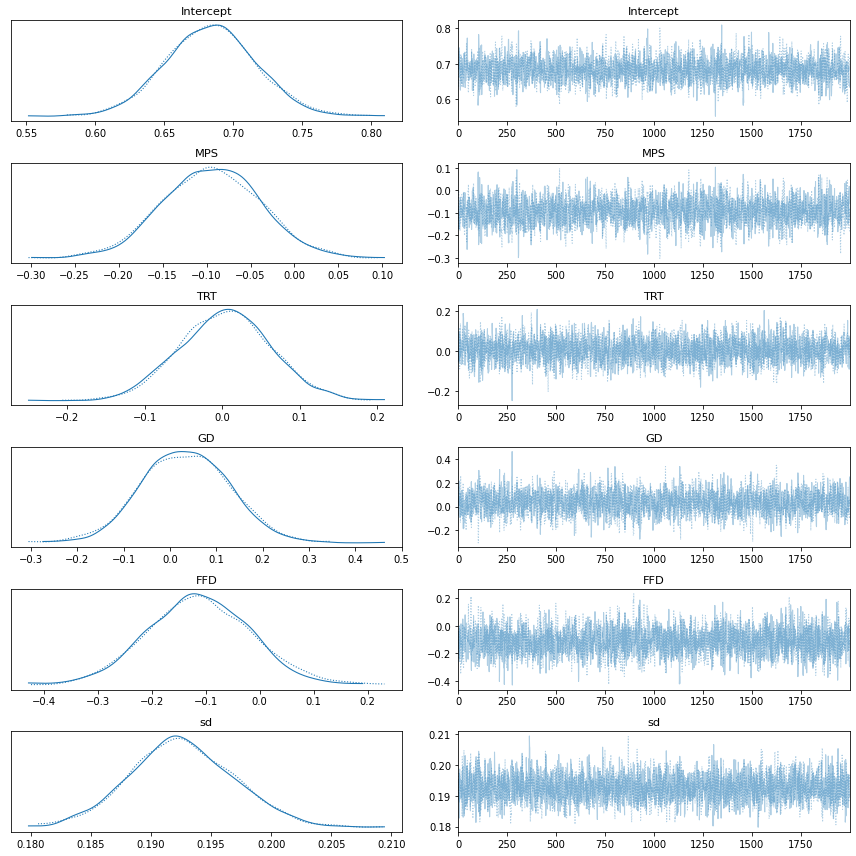

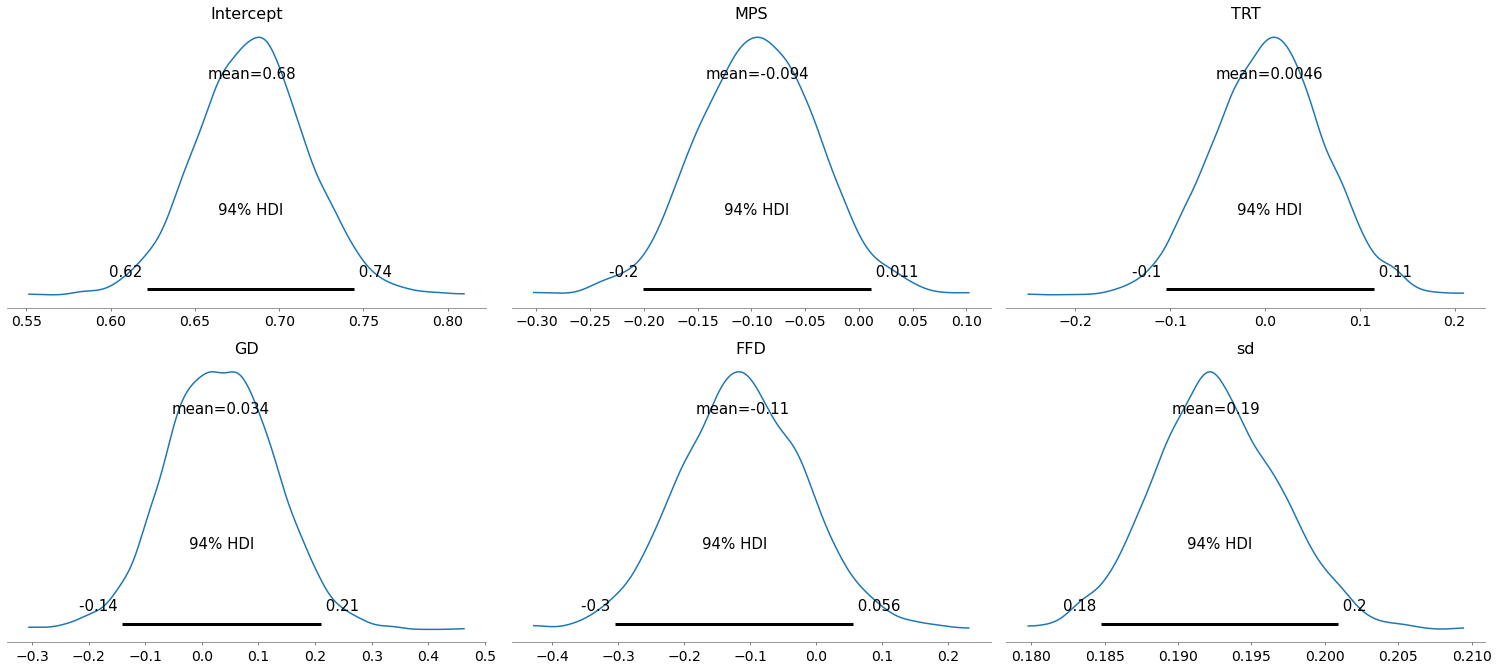

In [10]:
plt.figure(figsize=(7, 7))
traceplot(normal_trace)
plt.tight_layout();
pm.plot_posterior(normal_trace)

In [11]:
median_pred = Valence.median()
median_preds = [median_pred for _ in range(len(Valence))]
true = Valence
# Display mae and rmse
mae, rmse = evaluate_prediction(median_preds, true)
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Root Mean Square Error: {:.4f}'.format(rmse))

Mean Absolute Error: 0.1489
Root Mean Square Error: 0.1931


In [12]:
az.summary(normal_trace, round_to=2)

c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.68,0.03,0.62,0.74,0.0,0.0,2166.34,2148.04,2181.67,1994.50,1.0
MPS,-0.09,0.06,-0.20,0.01,0.0,0.0,2164.08,1912.94,2173.26,2141.39,1.0
TRT,0.00,0.06,-0.10,0.11,0.0,0.0,2642.85,2211.01,2642.17,2731.60,1.0
GD,0.03,0.09,-0.14,0.21,0.0,0.0,2210.96,1930.42,2219.74,2472.52,1.0
FFD,-0.11,0.10,-0.30,0.06,0.0,0.0,2591.18,2518.65,2601.08,2553.41,1.0
sd,0.19,0.00,0.18,0.20,0.0,0.0,3236.45,3230.40,3243.96,2261.72,1.0


### Model building: ZuCo-VAD BLR: Dominance (No normalization for VAD)

In [14]:
DO_GF_cs = pd.DataFrame(zuco_do_cs, columns=['Dominance','MPS','TRT','GD','FFD'])
scaler = MinMaxScaler()

x = DO_GF_cs[['MPS','TRT','GD', 'FFD']]
x = pd.DataFrame(scaler.fit_transform(x), columns=['MPS','TRT','GD','FFD'])
Dominance = DO_GF_cs['Dominance']

formula = 'Dominance ~ ' + ' + '.join(['%s' % variable for variable in x.columns[:]])
print(formula)

Dominance ~ MPS + TRT + GD + FFD


In [15]:
with pm.Model() as normal_model:
        
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
# Creating the model requires a formula and data (and optionally a family)
    model = pm.GLM.from_formula(formula, data = x, family = family)
# Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500)
#model.summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, FFD, GD, TRT, MPS, Intercept]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 2593 seconds.


c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
<ipython-input-16-f4abab5c2ed6>:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout();
c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'MPS'}>,
        <AxesSubplot:title={'center':'TRT'}>],
       [<AxesSubplot:title={'center':'GD'}>,
        <AxesSubplot:title={'center':'FFD'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

<Figure size 504x504 with 0 Axes>

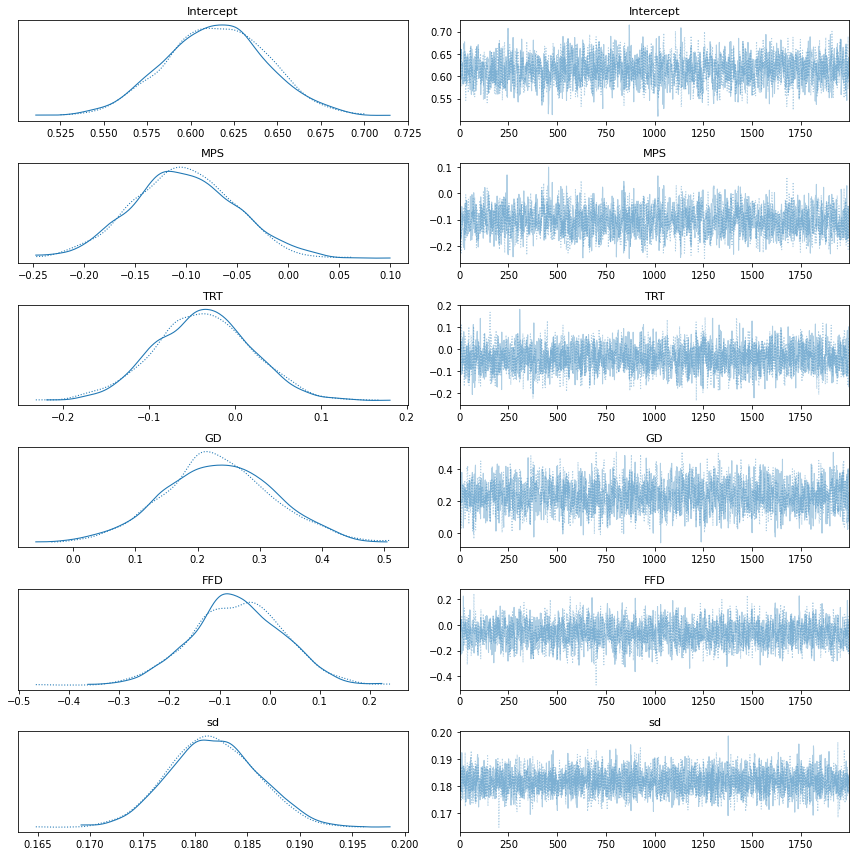

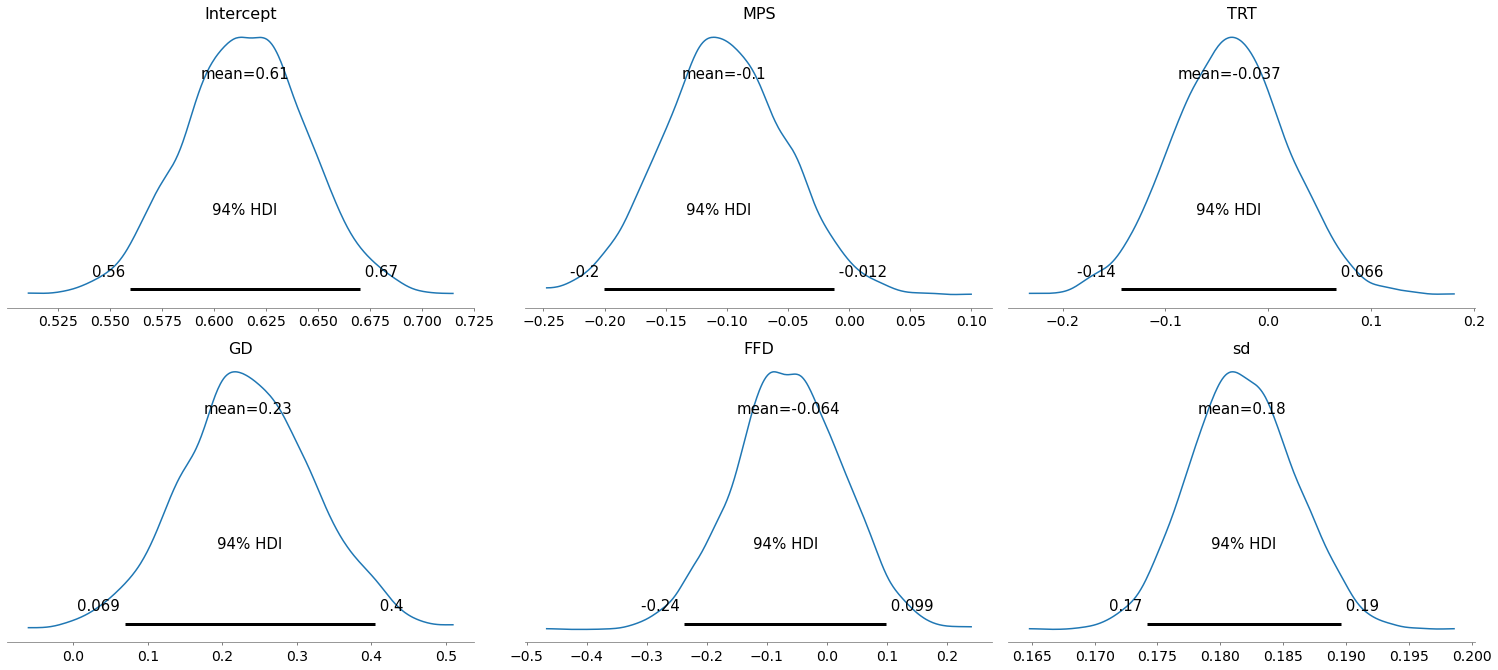

In [16]:
plt.figure(figsize=(7, 7))
traceplot(normal_trace)
plt.tight_layout();
pm.plot_posterior(normal_trace)

In [17]:
median_pred = Dominance.median()
median_preds = [median_pred for _ in range(len(Dominance))]
true = Dominance
# Display mae and rmse
mae, rmse = evaluate_prediction(median_preds, true)
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Root Mean Square Error: {:.4f}'.format(rmse))

Mean Absolute Error: 0.1501
Root Mean Square Error: 0.1826


In [18]:
az.summary(normal_trace, round_to=2)

c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.61,0.03,0.56,0.67,0.0,0.0,1842.54,1842.54,1845.71,2474.91,1.0
MPS,-0.10,0.05,-0.20,-0.01,0.0,0.0,1829.07,1829.07,1829.81,2182.12,1.0
TRT,-0.04,0.06,-0.14,0.07,0.0,0.0,2679.00,2572.83,2687.97,2499.51,1.0
GD,0.23,0.09,0.07,0.40,0.0,0.0,1969.27,1899.27,1964.11,2160.52,1.0
FFD,-0.06,0.09,-0.24,0.10,0.0,0.0,2141.44,2036.02,2143.16,2392.59,1.0
sd,0.18,0.00,0.17,0.19,0.0,0.0,3638.88,3633.75,3635.91,2814.14,1.0


In [4]:
scaler = MinMaxScaler()
AR_GF_cs = pd.DataFrame(zuco_ar_cs, columns=['Arousal','MPS','TRT','GD','FFD'])
AR_GF_cs = pd.DataFrame(scaler.fit_transform(AR_GF_cs), columns=['Arousal', 'MPS','TRT','GD','FFD'])

VA_GF_cs = pd.DataFrame(zuco_va_cs, columns=['Valence','MPS','TRT','GD','FFD'])
VA_GF_cs = pd.DataFrame(scaler.fit_transform(VA_GF_cs), columns=['Valence', 'MPS','TRT','GD','FFD'])

DO_GF_cs = pd.DataFrame(zuco_do_cs, columns=['Dominance','MPS','TRT','GD','FFD'])
DO_GF_cs = pd.DataFrame(scaler.fit_transform(DO_GF_cs), columns=['Dominance', 'MPS','TRT','GD','FFD'])

In [6]:
import time
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.model_selection import train_test_split
from RegscorePy import *

Text(0.5, 1.0, 'Information-criterion for model selection (training time 0.004s)')

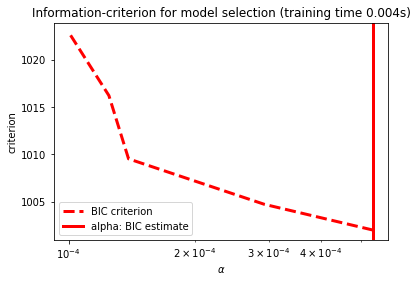

In [19]:
x = AR_GF_cs[['MPS','TRT','GD', 'FFD']]
Arousal = AR_GF_cs['Arousal']
# This is to avoid division by zero while doing np.log10
EPSILON = 1e-4

model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(x, Arousal)
alpha_bic_ = model_bic.alpha_

def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    plt.semilogx(model.alphas_ + EPSILON, criterion_, '--', color=color,
                 linewidth=3, label='%s criterion' % name)
    plt.axvline(model.alpha_ + EPSILON, color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel(r'$\alpha$')
    plt.ylabel('criterion')
    
plt.figure()
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection')

Text(0.5, 1.0, 'Information-criterion for model selection (training time 0.002s)')

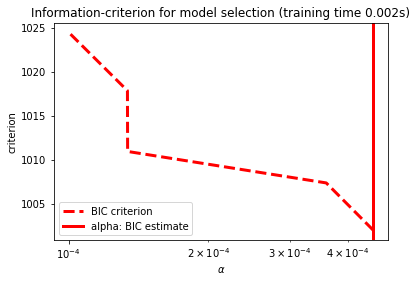

In [20]:
x = VA_GF_cs[['MPS','TRT','GD', 'FFD']]
Valence = VA_GF_cs['Valence']

EPSILON = 1e-4

model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(x, Valence)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_
    
plt.figure()
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)

Text(0.5, 1.0, 'Information-criterion for model selection (training time 0.002s)')

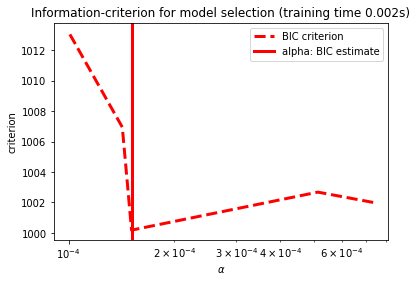

In [21]:
x = DO_GF_cs[['MPS','TRT','GD', 'FFD']]
Dominance = DO_GF_cs['Dominance']

EPSILON = 1e-4

model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(x, Valence)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

    
plt.figure()
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)

### Model building: ZuCo-VAD BLR: Arousal (VAD normalized)

In [17]:
x = AR_GF_cs[['MPS','TRT','GD', 'FFD']]
Arousal = AR_GF_cs['Arousal']

#Arousal = pd.DataFrame(scaler.fit_transform(Arousal), columns=['Arousal'])

formula = 'Arousal ~ ' + ' + '.join(['%s' % variable for variable in x.columns[:]])
print(formula)

Arousal ~ MPS + TRT + GD + FFD


In [18]:
with pm.Model() as normal_model:
        
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
# Creating the model requires a formula and data (and optionally a family)
    model = pm.GLM.from_formula(formula, data = x, family = family)
# Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500)
#model.summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, FFD, GD, TRT, MPS, Intercept]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 2728 seconds.
The acceptance probability does not match the target. It is 0.8902746570286971, but should be close to 0.8. Try to increase the number of tuning steps.


c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
<ipython-input-21-a8bf0700fcbe>:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout();
c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Mean Absolute Error: 0.1525
Root Mean Square Error: 0.1908


c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.45,0.03,0.39,0.50,0.0,0.0,2146.41,2146.41,2160.07,2355.04,1.0
MPS,-0.05,0.05,-0.15,0.04,0.0,0.0,2060.45,1958.08,2072.30,2188.81,1.0
TRT,-0.02,0.06,-0.13,0.09,0.0,0.0,2499.87,1695.29,2509.11,2330.94,1.0
GD,0.17,0.09,-0.00,0.35,0.0,0.0,2199.40,1975.10,2197.17,2316.26,1.0
FFD,-0.06,0.09,-0.23,0.12,0.0,0.0,2285.29,1969.23,2285.83,2470.44,1.0
sd,0.19,0.00,0.18,0.20,0.0,0.0,3170.90,3170.90,3176.91,2506.94,1.0


<Figure size 504x504 with 0 Axes>

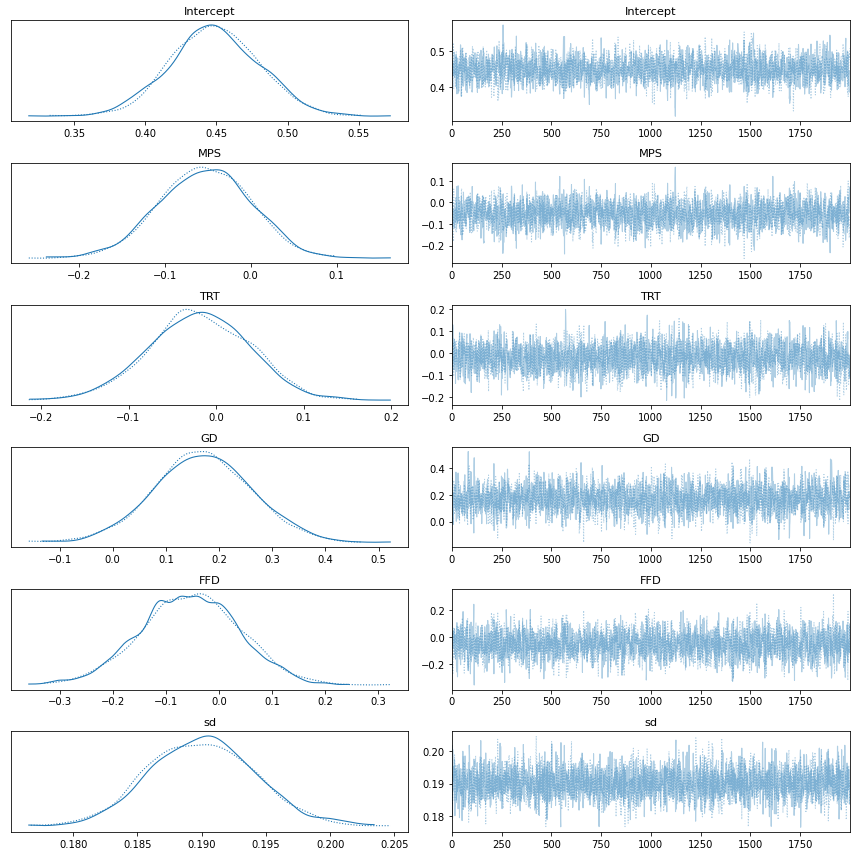

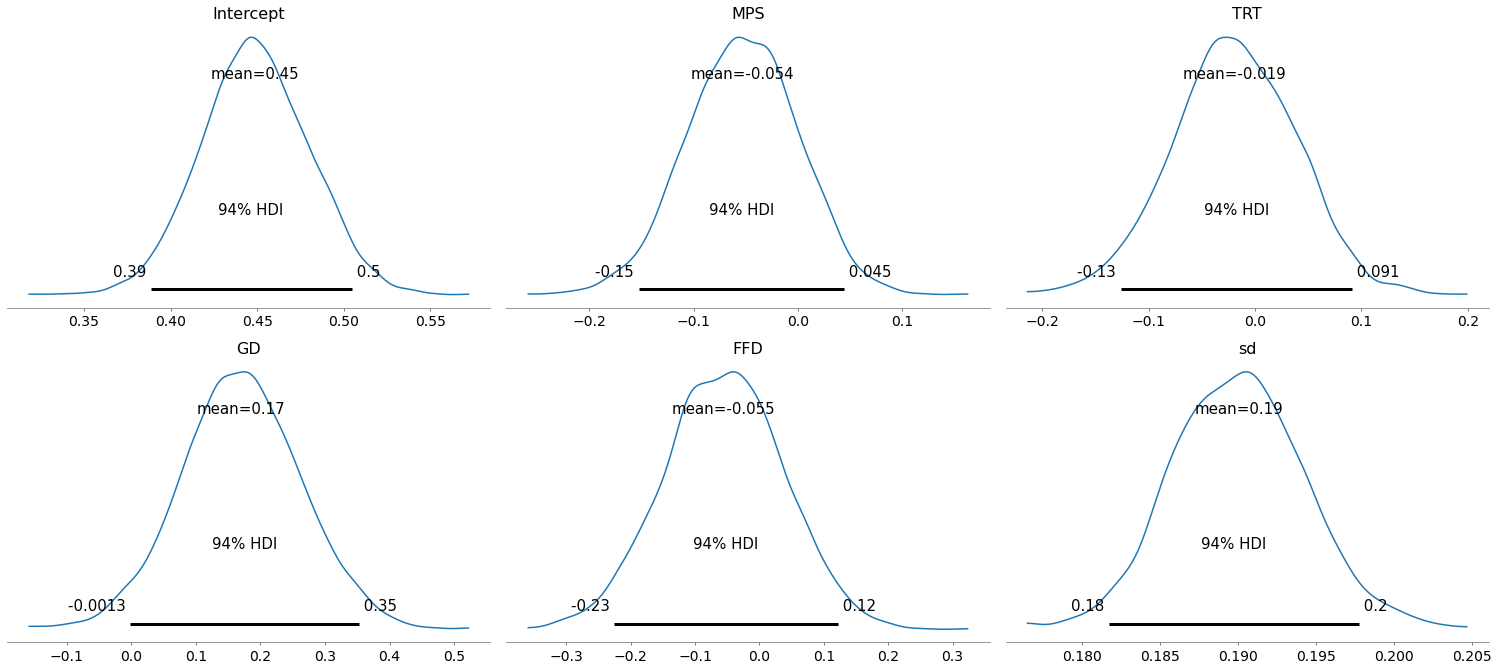

In [21]:
plt.figure(figsize=(7, 7))
traceplot(normal_trace)
plt.tight_layout();
pm.plot_posterior(normal_trace)

median_pred = Arousal.median()
median_preds = [median_pred for _ in range(len(Arousal))]
true = Arousal
# Display mae and rmse
mae, rmse = evaluate_prediction(median_preds, true)
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Root Mean Square Error: {:.4f}'.format(rmse))

az.summary(normal_trace, round_to=2)

### Model building: ZuCo-VAD BLR: Valence (VAD normalized)

In [22]:
x = VA_GF_cs[['MPS','TRT','GD', 'FFD']]
Valence = VA_GF_cs['Valence']

formula = 'Valence ~ ' + ' + '.join(['%s' % variable for variable in x.columns[:]])
print(formula)

Valence ~ MPS + TRT + GD + FFD


In [23]:
with pm.Model() as normal_model:
        
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
# Creating the model requires a formula and data (and optionally a family)
    model = pm.GLM.from_formula(formula, data = x, family = family)
# Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500)
#model.summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, FFD, GD, TRT, MPS, Intercept]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 2657 seconds.


c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
<ipython-input-24-b8b9a902e6de>:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout();
c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Mean Absolute Error: 0.1504
Root Mean Square Error: 0.1950


c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.68,0.03,0.63,0.74,0.0,0.0,2515.34,2515.34,2530.89,2587.68,1.0
MPS,-0.09,0.05,-0.19,0.00,0.0,0.0,2399.89,2333.15,2394.92,2456.12,1.0
TRT,0.01,0.06,-0.10,0.12,0.0,0.0,3165.03,2125.51,3161.88,2946.00,1.0
GD,0.03,0.09,-0.14,0.21,0.0,0.0,2334.06,2026.01,2333.69,2426.74,1.0
FFD,-0.11,0.10,-0.30,0.06,0.0,0.0,2453.54,2268.55,2462.27,2765.06,1.0
sd,0.19,0.00,0.19,0.20,0.0,0.0,2861.69,2861.69,2862.79,2384.16,1.0


<Figure size 504x504 with 0 Axes>

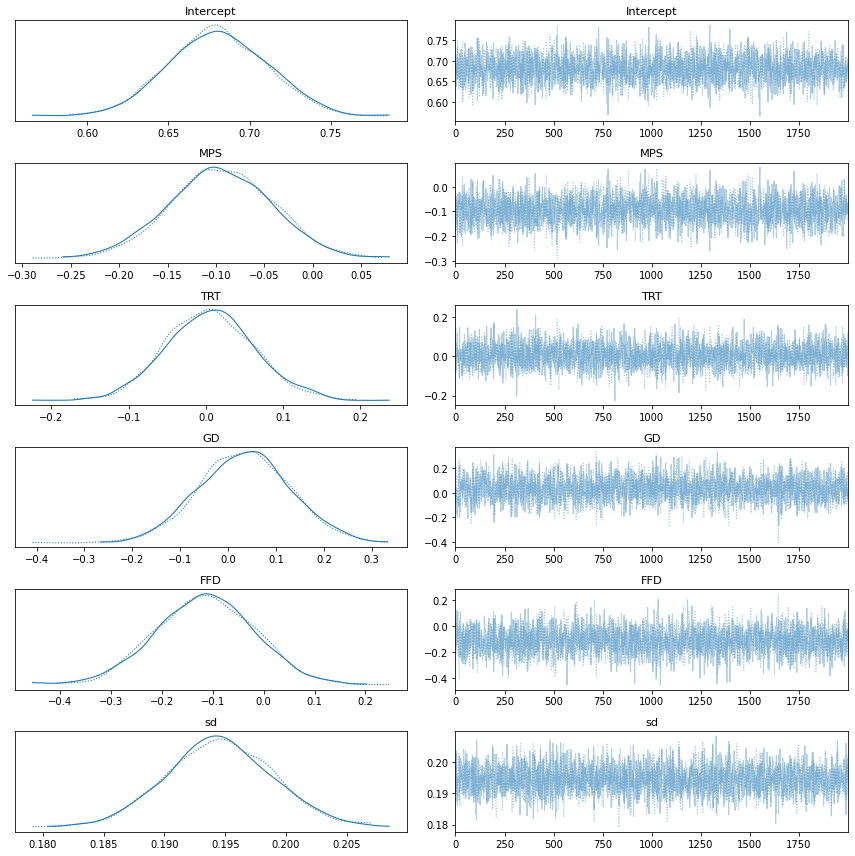

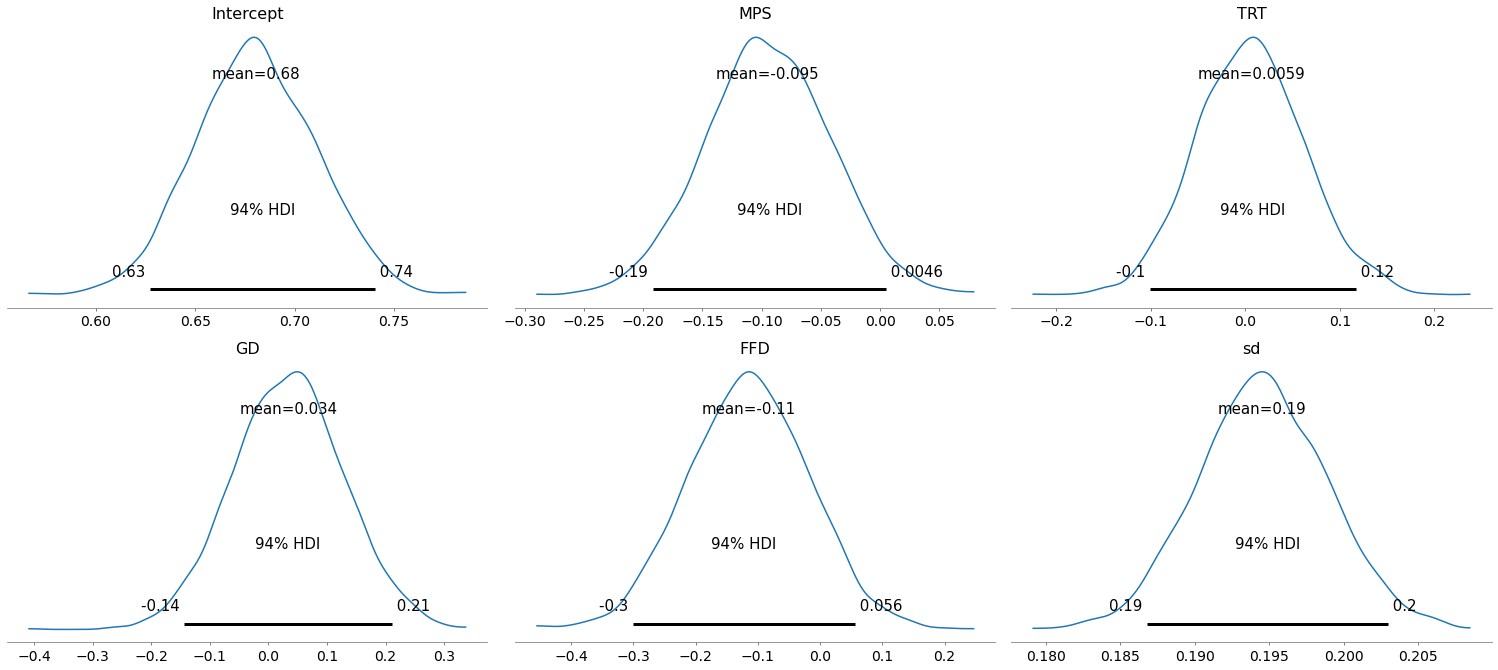

In [24]:
plt.figure(figsize=(7, 7))
traceplot(normal_trace)
plt.tight_layout();
pm.plot_posterior(normal_trace)

median_pred = Valence.median()
median_preds = [median_pred for _ in range(len(Valence))]
true = Valence
# Display mae and rmse
mae, rmse = evaluate_prediction(median_preds, true)
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Root Mean Square Error: {:.4f}'.format(rmse))

az.summary(normal_trace, round_to=2)

### Model building: ZuCo-VAD BLR: Dominance (VAD normalized)

In [25]:
x = DO_GF_cs[['MPS','TRT','GD', 'FFD']]
Dominance = DO_GF_cs['Dominance']

formula = 'Dominance ~ ' + ' + '.join(['%s' % variable for variable in x.columns[:]])
print(formula)

Dominance ~ MPS + TRT + GD + FFD


In [26]:
with pm.Model() as normal_model:
        
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
# Creating the model requires a formula and data (and optionally a family)
    model = pm.GLM.from_formula(formula, data = x, family = family)
# Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500)
#model.summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, FFD, GD, TRT, MPS, Intercept]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 2718 seconds.
The acceptance probability does not match the target. It is 0.8815691065420637, but should be close to 0.8. Try to increase the number of tuning steps.


c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
<ipython-input-27-e4479a2d9eeb>:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout();
c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Mean Absolute Error: 0.1675
Root Mean Square Error: 0.2038


c:\users\fra\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.59,0.03,0.53,0.65,0.0,0.0,2297.30,2297.30,2298.81,2623.43,1.0
MPS,-0.12,0.06,-0.22,-0.02,0.0,0.0,2234.51,2136.17,2237.67,2452.03,1.0
TRT,-0.04,0.06,-0.15,0.08,0.0,0.0,2774.21,2563.69,2768.22,2240.24,1.0
GD,0.26,0.10,0.07,0.44,0.0,0.0,2516.84,2511.74,2512.41,2820.34,1.0
FFD,-0.07,0.10,-0.25,0.13,0.0,0.0,2883.20,2770.03,2904.65,2650.12,1.0
sd,0.20,0.00,0.19,0.21,0.0,0.0,3120.84,3113.83,3131.67,2560.06,1.0


<Figure size 504x504 with 0 Axes>

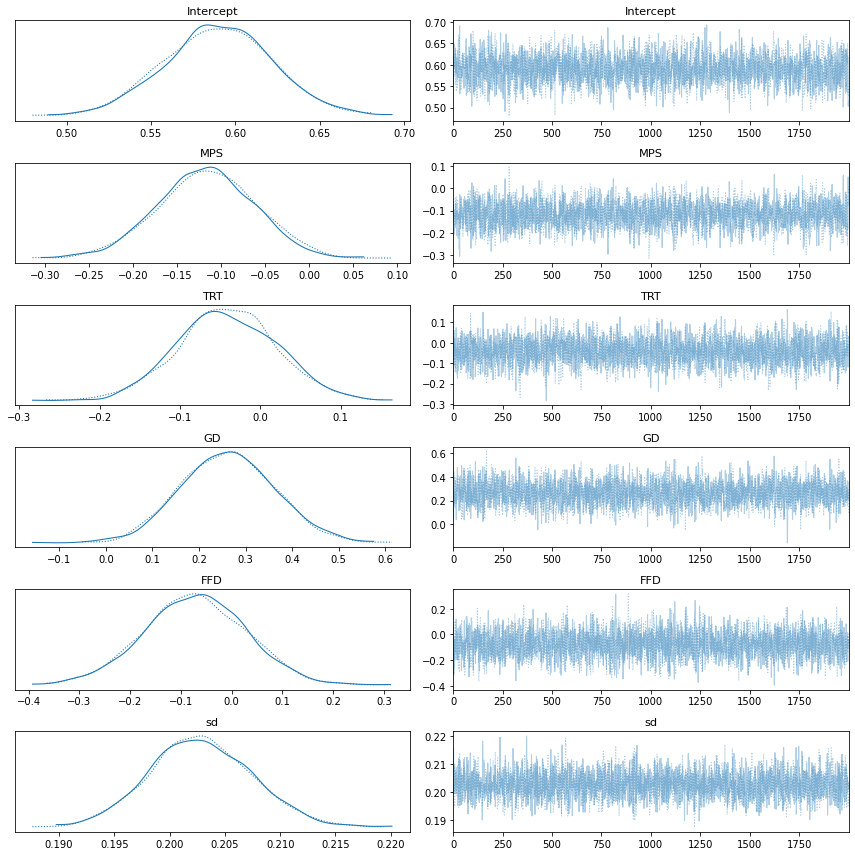

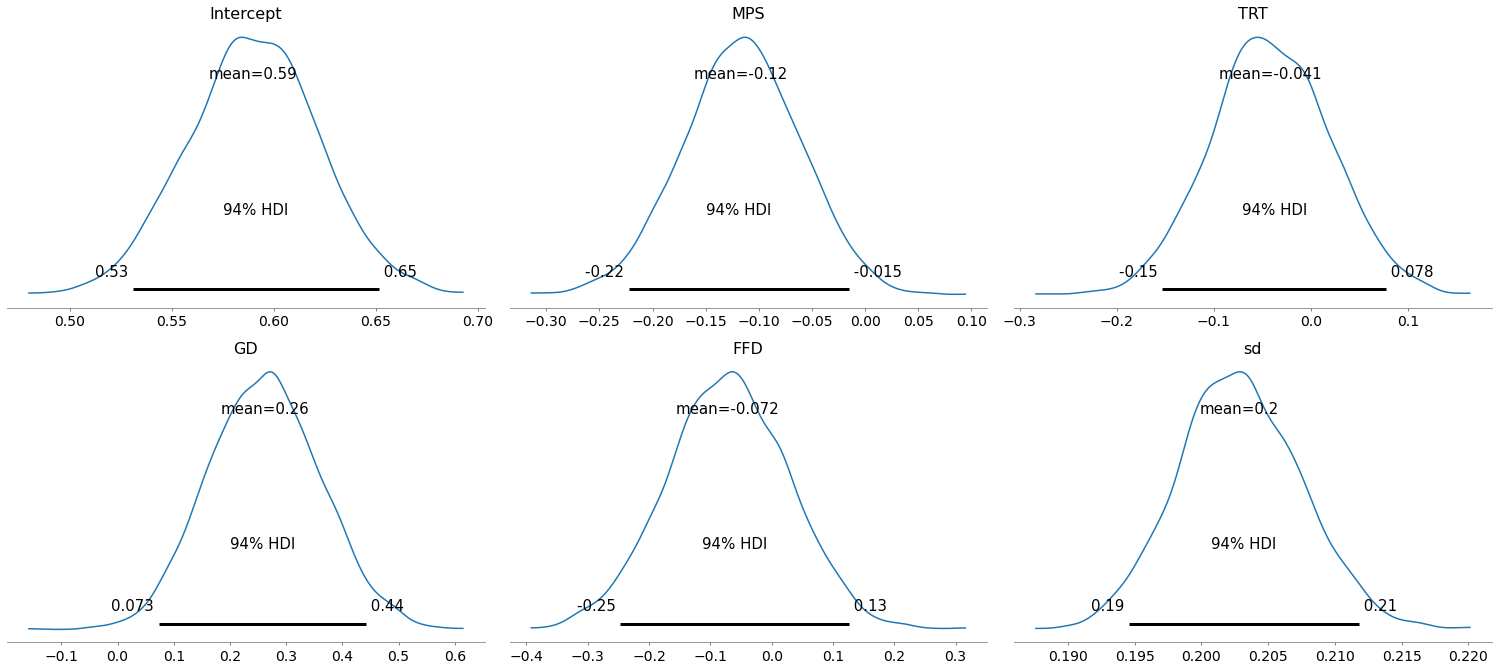

In [27]:
plt.figure(figsize=(7, 7))
traceplot(normal_trace)
plt.tight_layout();
pm.plot_posterior(normal_trace)

median_pred = Dominance.median()
median_preds = [median_pred for _ in range(len(Dominance))]
true = Dominance
# Display mae and rmse
mae, rmse = evaluate_prediction(median_preds, true)
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Root Mean Square Error: {:.4f}'.format(rmse))

az.summary(normal_trace, round_to=2)